In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchmetrics.regression import CosineSimilarity

import os, sys
sys.path.append("..")

from src import utils
from src.models.concept_module import ConceptVectorModule
import pandas as pd


In [2]:
device = torch.cuda.device(1)
import torchxrayvision as xrv 

clf = xrv.models.DenseNet(weights="all").to(device=0)


In [42]:
from torchsampler import ImbalancedDatasetSampler
from torchvision.transforms import Compose
from torchxrayvision.datasets import XRayCenterCrop, XRayResizer, normalize, apply_transforms, relabel_dataset, SubsetDataset
from datawrappers import NIH_wrapper, CheX_wrapper, VINBig_wrapper

transforms = Compose([XRayCenterCrop(),XRayResizer(224)])
nih_ds = NIH_wrapper(r"/mnt/mp1/@ais/nih_raw/%ob/",\
    csvpath=r"/mnt/mp1/@ais/nih_raw/%ob/Data_Entry_2017_v2020.csv",\
    bbox_list_path=r"/mnt/mp1/@ais/nih_raw/%ob/BBox_List_2017.csv",\
    unique_patients=True,
    transform=transforms)
relabel_dataset(clf.pathologies,nih_ds,silent=False)

target = "Atelectasis"
sampler=ImbalancedDatasetSampler(nih_ds,callback_get_label=lambda x: x.labels[:,nih_ds.pathologies.index(target)])
nih_loader = torch.utils.data.DataLoader(nih_ds,batch_size=300,sampler=sampler,pin_memory=False)

chex_ds = CheX_wrapper(r"/mnt/mp1/@ais/chexpert_raw/%ob/CheXpert-v1.0-small",r"/mnt/mp1/@ais/chexpert_raw/%ob/CheXpert-v1.0-small/train.csv",transform=transforms)
relabel_dataset(clf.pathologies,chex_ds,silent=False)
chex_ds.labels = np.nan_to_num(chex_ds.labels,0)
sampler=ImbalancedDatasetSampler(chex_ds,callback_get_label=lambda x: x.labels[:,chex_ds.pathologies.index(target)])
chex_loader = torch.utils.data.DataLoader(chex_ds,batch_size=300,sampler=sampler,pin_memory=False)



Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.
{'Pleural Other', 'Support Devices'} will be dropped
Infiltration doesn't exist. Adding nans instead.
Emphysema doesn't exist. Adding nans instead.
Fibrosis doesn't exist. Adding nans instead.
Pleural_Thickening doesn't exist. Adding nans instead.
Nodule doesn't exist. Adding nans instead.
Mass doesn't exist. Adding nans instead.
Hernia doesn't exist. Adding nans instead.


In [43]:
nih_ds.pathologies

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']

In [44]:
for x in chex_loader:
    break

In [45]:
concept = x["lab"][:,clf.pathologies.index("Cardiomegaly")].bool()


In [46]:
x['img'][~concept].shape

torch.Size([263, 1, 224, 224])

In [25]:
from sklearn.linear_model import LogisticRegression

def calculate_vectors(emb_pos, emb_neg):
    cav_model = LogisticRegression()
    x_train = np.concatenate(
        [
            emb_pos.detach().cpu().flatten(start_dim=1).numpy(),
            emb_neg.detach().cpu().flatten(start_dim=1).numpy(),
        ]
    )
    concept = np.concatenate(
        [np.ones(emb_pos.shape[0]), np.zeros(emb_neg.shape[0])]
    )
    cav_model.fit(x_train, concept)
    if len(cav_model.coef_) == 1:
        cav = torch.tensor(-cav_model.coef_[0])
    else:
        cav = -torch.tensor(cav_model.coef_)
    return cav

def step(model, batch,concept):
    img = batch["img"]
    concept = batch["label"][:,concept].bool()

    with torch.no_grad():
        emb_pos = model.features2(img[concept])
        emb_neg = model.features2(img[~concept])
    # pos_grad = self.get_gradient(emb_pos)
    # neg_grad = self.get_gradient(emb_neg)
    return emb_pos, emb_neg


In [47]:
def get_cavs(loader, limit=10): 
    cavs = []
    for i,batch in enumerate(loader):
        batch['img'] = batch['img'].to(device=0)
        if "lab" in batch.keys():
            batch['label'] = batch['lab']
        emb_pos, emb_neg = step(clf,batch,concept=clf.pathologies.index("Atelectasis"))
        print(len(emb_pos)/len(emb_neg))
        cavs.append(calculate_vectors(emb_pos, emb_neg))
        if i == limit:
            break
    return cavs

nih_cavs = get_cavs(nih_loader)
chexpert_train_cavs = get_cavs(chex_loader)

def calculate_similarity(a,b):
    return [[CosineSimilarity()(tr_cav,ts_cav) for ts_cav in b] for tr_cav in a]


1.0134228187919463
1.0547945205479452
1.2900763358778626
0.910828025477707
1.158273381294964
1.097902097902098
1.0
0.9354838709677419
0.9607843137254902
1.158273381294964
0.910828025477707
0.9230769230769231
1.0408163265306123
1.097902097902098
0.9867549668874173
1.3255813953488371
0.9230769230769231
0.948051948051948
0.948051948051948
0.9607843137254902
0.8292682926829268
0.9736842105263158


In [65]:
random = [torch.randn(1024) for x in range(11)]

In [67]:

sim = calculate_similarity(nih_cavs,random)
print(np.mean(sim))
print(np.std(sim))

-0.0006600735
0.032310855


In [63]:
np.min(sim)

-0.035630886

In [43]:
np.std(np.array(sim).flatten())

0.13715424

In [149]:
def show_sim_plot(name1,name2,v1,v2):
    fig, ax = plt.subplots()
    ax.matshow(calculate_similarity(v1,v2))
    ax.set_xticklabels([f"{name2} vector {i}" for i in range(0,len(v2)+1)], rotation=45)
    ax.set_yticklabels([f"{name1} vector {i}" for i in range(0,len(v1)+1)])
    for (i, j), z in np.ndenumerate(calculate_similarity(v1,v2)):
        ax.text(j-0.25, i, '{:0.3f}'.format(z), ha='left')
    ax.text(-0.30, 1, "{}".format(model_n.split("-")[-1]), transform=ax.transAxes, fontsize=10) 

show_sim_plot("nih train","nih train",nih_cavs,nih_cavs)
show_sim_plot("chexpert train","chexpert train",chexpert_train_cavs,chexpert_train_cavs)
show_sim_plot("chexpert train","chexpert test",chexpert_train_cavs,chexpert_test_cavs)
show_sim_plot("nih train","chexpert train",nih_cavs,chexpert_train_cavs)
show_sim_plot("chexpert train","random",chexpert_train_cavs,[torch.randn(1024) for x in range(4)])
show_sim_plot("nih train","random",nih_cavs,[torch.randn(1024) for x in range(4)])
show_sim_plot("nih mean train","chexpert train",[torch.mean(torch.stack(nih_cavs),dim=0)],[torch.randn(1024) for x in range(4)])


RuntimeError: Predictions and targets are expected to have the same shape

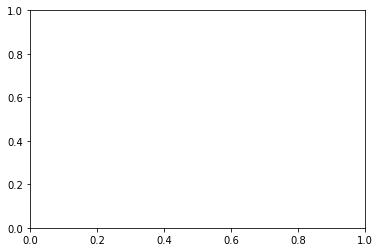

In [150]:
show_sim_plot("nih train","chexpert train",torch.mean(torch.stack(nih_cavs),dim=1),chexpert_train_cavs)

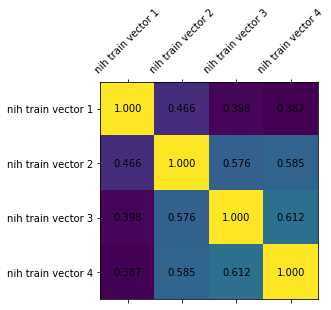

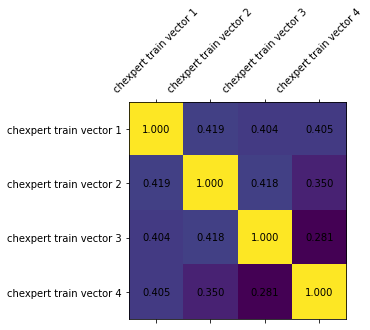

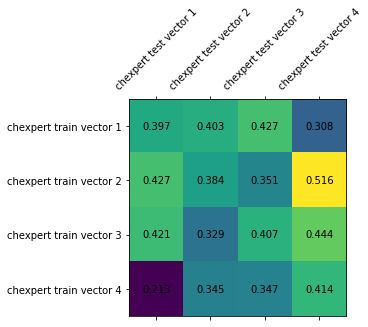

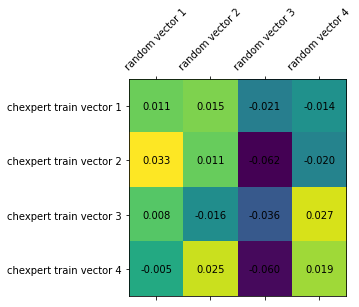

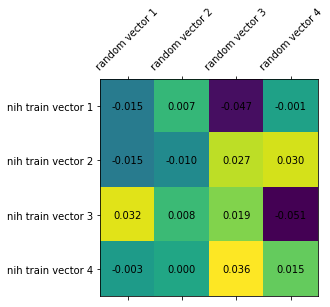

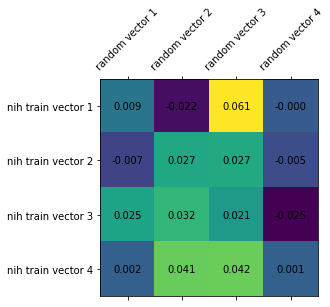

In [19]:
calculate_similarity({"name":"nih_test","cavs":nih_test_cavs},{"name":"chexpert_test_cavs","cavs":chexpert_test_cavs})

Cosine similarity between nih_test and chexpert_test_cavs
tensor(0.0505)
tensor(0.1482)
tensor(0.0539)
tensor(0.1272)
tensor(0.1198)
tensor(0.2582)
tensor(0.2189)
tensor(0.2544)
tensor(0.0209)
tensor(0.1980)
tensor(0.2083)
tensor(0.2174)
tensor(0.0443)
tensor(0.2276)
tensor(0.1299)
tensor(0.2431)


In [20]:
calculate_similarity({"name":"chexpert_test","cavs":chexpert_test_cavs},{"name":"random_cavs","cavs":[torch.randn(1024) for x in range(3)]})

Cosine similarity between chexpert_test and random_cavs
tensor(-0.0202)
tensor(0.0059)
tensor(-0.0166)
tensor(0.0035)
tensor(0.0169)
tensor(-0.0541)
tensor(-0.0591)
tensor(0.0271)
tensor(-0.0086)
tensor(0.0402)
tensor(-0.0132)
tensor(-0.0550)


In [21]:
calculate_similarity({"name":"chexpert_train_mean","cavs":[torch.mean(torch.stack(chexpert_train_cavs),dim=0)]},{"name":"nih_train","cavs":nih_cavs})

Cosine similarity between chexpert_train_mean and nih_train
tensor(0.1957)
tensor(0.1785)
tensor(0.2543)
tensor(0.3236)


In [22]:
calculate_similarity({"name":"nih_mean","cavs":[torch.mean(torch.stack(nih_cavs),dim=0)]},{"name":"nih_test","cavs":nih_test_cavs})

Cosine similarity between nih_mean and nih_test
tensor(0.5012)
tensor(0.4698)
tensor(0.5254)
tensor(0.5819)


In [23]:
calculate_similarity({"name":"chexpert_test_cavs","cavs":chexpert_test_cavs},{"name":"chexpert_test_cavs","cavs":chexpert_test_cavs})

Cosine similarity between chexpert_test_cavs and chexpert_test_cavs
tensor(1.)
tensor(0.2175)
tensor(0.0952)
tensor(0.0883)
tensor(0.2175)
tensor(1.0000)
tensor(0.2382)
tensor(0.3131)
tensor(0.0952)
tensor(0.2382)
tensor(1.0000)
tensor(0.2284)
tensor(0.0883)
tensor(0.3131)
tensor(0.2284)
tensor(1.0000)


In [24]:
calculate_similarity({"name":"nih_test_cavs","cavs":nih_test_cavs},{"name":"nih_test_cavs","cavs":nih_test_cavs})

Cosine similarity between nih_test_cavs and nih_test_cavs
tensor(1.0000)
tensor(0.3802)
tensor(0.3445)
tensor(0.5076)
tensor(0.3802)
tensor(1.)
tensor(0.4545)
tensor(0.4306)
tensor(0.3445)
tensor(0.4545)
tensor(1.)
tensor(0.4232)
tensor(0.5076)
tensor(0.4306)
tensor(0.4232)
tensor(1.)
